### Choosing a metric

I first looked at class ditribution. There are two classes. The dataset is highly imbalanced because the positive class makes up only ~0.19% of all labels.

I suspected if I just run a simple logistic regression on the dataset, I could achieve 99.81% accuracy, because the model can simply cheat by classifying every sample as 0. I ran logistic regression using sklearn with default params, and the result confirmed my hypothesis - the model predicted every sample as 0.

Accuracy is a bad metric for an imbalanced dataset. If the model predicts the majority label for every sample, precision will be perfect but recall will be 0. If the model predicts the minority label for every sample, the recall will be perfect but precision will be 1. One potential metric I can use is the f1 score, but it assumes that precision and recall are equally important, which in reality may not be true. If capturing most of the click-throughs are more important than serving efficiency (most of the served impressions result in click-throughs, in other words, there is no infrastructure bottlenck), then recall is more important than precision. On the other hand, if serving efficiency is more important than capturing most of click-throughs, which may be true when the scale is large, then precision is more important.

Without making too much an assumption, ROC AUC is a better metric to use because it shows the tradeoff between specificity and senstivity. A large ROC AUC value indicates the model is more robust, and the optimal value should approach 1.

### Baseline models

#### Logistic Regression
I reran the default logistic regression model (no penalty, all params left as default set by sklearn) and printed ROC AUC, f1 score and the confusion matrix. I used the binary labels as predicted values rather than scores, because I didn't want ROC AUC to be skewed by precision, and I care more about the repdiced labels than probablities (although this is likely not the best idea in real life, if probablities are used for calculating the cost per click).
```
================================
Confusion Matrix:
True Negative = 199623
False Negative = 377
True Positive = 0
False Positive = 0
================================
f1 score = 0.000
================================
ROC AUC Score = 0.500
```
F1 score is forced to 0 because there are no predicted positives at all. ROC AUC score is low - only as good as a random classifier. Not expecting much to change, I added l2 regularization `penalty='l2'`, the result is the same. The imbalance is to0 strong for the model to try to predict positives.

#### Neural Net
The baseline neural net has 1 hidden layer that outputs 88 weights for all features, and an output layer with 2 outputs, one probability for each class, with a softmax activation. Categorical crossentropy is used as loss.

The model was fit with 3 epochs, and a batch size of 32. The baseline neural net should be equivalent of a logisc regression, except that I used the SGD optimizer. I picked a learning rate of 0.01 (it usually worked well for me). I set the inital weights as `Ones`, because Keras defaults the inital weights to `glorot_uniform`, which generally works really well, and too well for a baseline model).

I used set split to 0.2 for validation after each epoch.
Both training and validation error went down, and validation error was slightly smaller than training error in all epochs, indicating no overfitting. 

Unsurprisingly, the accuracy was still 99.81%, with the vast majority of samples predicted negative. ROC AUC score was still 0.5.

The result:
```
================================
Confusion Matrix:
True Negative = 199619
False Negative = 377
True Positive = 0
False Positive = 4
================================
f1 score = 0.000
================================
ROC AUC Score = 0.500
```

Because I set the initial weights to `Ones`, I wanted to eliminate the possibility that my weights were either too big or too samll. I checked the hidden layer's output weights, they were all between -1 and 1. I removed the initial weights so that they were set to `glorot_uniform`, the result was similar, there was one true positive and more false positives
```
================================
Confusion Matrix:
True Negative = 199418
False Negative = 376
True Positive = 1
False Positive = 205
================================
f1 score = 0.003
================================
ROC AUC Score = 0.501
```

### Model improvements
I thought the main obstacle to achieving higher ROC AUC is the severe data imbalance. I could try

- Deepen the neural network model
  <p>
    If add more layers, the model will have a chance to explore nonlinearty, which might cover the positive space.
  </p>
- Down sampling
  <p>
    The negative class can be overpowering. I can find a good class ratio so that the model can be trained for positive classes without underfitting the negative class. A side benefit is the model will take less time to train.
  </p>
- Over sampling
  <p>
    Like down sampling, the goal is to make the data more balanced. If there is underfitting for the negative class, I can try oversampling the positive class and find a good class ratio. Oversampling can be done with random selection and duplication. This can cause overfitting for the positive class, and slow down training and can increase model size.
  </p>
- SMOTE
  <p>
    I can also try a hybrid approach, down sample negative class while generating synthetic samples for the positive class eith nearest neighbours. This could help prevent positive class overfitting. But just like oversampling, it causes the model to train slower and the size to increase.
  </p>
  
  
#### Deepen the neural network model
I added one more hidden layer with 64 outputs, without any regularization, and left the initial weights to `glorot_uniform`. Both training and validation lossses are smaller (around 0.015 v.s. 0.030 in the baseline neural net). However, there is no improvement in metrics. The vast majority of predicted clases are still negative, and ROC AUC remains 0.5. The validation error also failed to decrease while training error did. To reduce overfitting, so I added `l2(0.01)` to the first hidden layer. The validation error decreased with training error, but there was no improvement in metrics. In fact, the model predicted all negatives again. It was likely the extra layer only allowed the model to explore some nonlinearity and as a result the error declined, but it heavily benefited the negative samples, which severly outweighed the positive class.

I tried to tune learning rate (0.1, 0.001, 0.0001) and batch size (64, 128, 256) on different scales and different weight initializers (random normal, he_normal, etc). There was no improvement. Adding another layer didn't help either.

Since the imbalance was preventing the model from predicting positives, I used weighted loss to balance the classes by setting `class_weight` (roughly 1:526) in the `fit` function. The losses were large, and validation error plateaued, and the model again tried to predict all negatives. I probably overshot the class weight, so I adjusted to 1:100, and added l2(0.01). There were more false positives, but there was still overfitting, so I changed l2 to l1 in the first layer, in an attempt to reduce features. This helped. I have more true positives, but also more false positives, but the ROC AUC reached 0.541

```
================================
Confusion Matrix:
True Negative = 190136
False Negative = 328
True Positive = 49
False Positive = 9487
================================
f1 score = 0.010
================================
ROC AUC Score = 0.541
```

There was still a little overfitting, so I added a dropout layer between the two hidden layers at 0.1. However, this pushed the model back to all negatives again. I tried to tune the dropout rate and although it decreases losses when the rate is 0.05, it also prevented the mode from predicting positives, probably because most of the loss it regulated is from negatives. I also tuned the learn rate, decay, and tried out RMSprop. The loss went down but ROC AUC was stagnent.

I could keep adding layers and tuning the extra hyper parameters, but I decided to explore sampling techiniques, otherwise the model would be exponentially slower and harder to tune as trained parameters hyper parameters increase.

#### Undersampling/Oversampling
I used logistic regression to evaluate different sampling methods.

Initially I tried just random undersampling with a negative-positive ratio of 10:1. I tried 1:1 but this lead to overfitting due to extremely small positive size. 10:1 resulted in an ROC AUC score of 0.501. I used `class_weight` to counter balance so that to total weight of the two classes were equal (i.e. setting it to 1:10). ROC AUC score improved to 0.663.

```
================================
Confusion Matrix:
True Negative = 129499
False Negative = 122
True Positive = 255
False Positive = 70124
================================
f1 score = 0.007
================================
ROC AUC Score = 0.663
```

I tried random oversampling next. However, the sampling process was very slow this time, because I was upsampling the minority class to have an equal size with the majority class. So I put the undersampler before the oversampler, and built a pipeline.

```
Undersample majority to 10:1 -> Oversample minority to 1:1
```

Due to lack of positive samples, I worried simple oversampling would cause overfitting, as the classifier would memorize them. I built another pipeline with SMOTE as the second step.

```
Undersample majority to 10:1 -> SMOTE 1:1
```

The results:
```
================================
Confusion Matrix:
True Negative = 129713
False Negative = 123
True Positive = 254
False Positive = 69910
================================
f1 score = 0.007
================================
ROC AUC Score = 0.662
```

```
================================
Confusion Matrix:
True Negative = 130028
False Negative = 125
True Positive = 252
False Positive = 69595
================================
f1 score = 0.007
================================
ROC AUC Score = 0.660
```

There was little difference between oversampling vs SMOTE, and having an oversampling step didn't yield better results than only undersampling.

Because of undersampling, the overall size was still small. To prove I wasn't lucky, I removed the random seed and repeated the tests above 10 times and the results were similar.

I tuned the initial undersampling ratio higher, 20:1, and 40:1, the results were not better, but slightly worse. Maybe  higher undersampling ratio lead to more noisy oversampled data down the pipeline, as the minority class had to be sampled/synthesizes to a large size.

After a closer look at the sampling results above, SMOTE actually resulted in fewer false positives and more true negatives. I played around with `k_neighbors` and `m_neighbors`, and was able to reduce the false positives a little  further. The best config is `k_neighbors=1`, `m_neighbors=3`

```
================================
Confusion Matrix:
True Negative = 130268
False Negative = 125
True Positive = 252
False Positive = 69355
================================
f1 score = 0.007
================================
ROC AUC Score = 0.661
```

#### Ensembling
So far I hadn't spent much time on improving the undersampling. I saw decent improvement in ROC AUC score from 0.5 to 0.66, but false positives were still high. I stumbled upon `BalanceCascade` and wondered if more sophisticated estimators with iterative undersampling could help reduce potential noise in the features and negative samples.

I still had to undersample as the first step so that ensembling didn't take forever.

__EasyEnsembler__
No estimator, just iterative random undersampling
Results are in line with random undersampling
```
================================
Confusion Matrix:
True Negative = 126066
False Negative = 124
True Positive = 253
False Positive = 73557
================================
f1 score = 0.007
================================
ROC AUC Score = 0.651
```
__BalanceCascade__
Without an estimator, it uses KNN
```
================================
Confusion Matrix:
True Negative = 115446
False Negative = 149
True Positive = 228
False Positive = 84177
================================
f1 score = 0.005
================================
ROC AUC Score = 0.592
```

__BalanceCascade + DecisionTreeClassifier__
This is not bad as I left all params default.
```
================================
Confusion Matrix:
True Negative = 128417
False Negative = 152
True Positive = 225
False Positive = 71206
================================
f1 score = 0.006
================================
ROC AUC Score = 0.620
```
Since I didn't limit max subsets. I tried 20, 10, 5.
5 had the best result, with ROC AUC = 0.674, where as 20 -> 0.636, 10 -> 0.644.
```
================================
Confusion Matrix:
True Negative = 127183
False Negative = 109
True Positive = 268
False Positive = 72440
================================
f1 score = 0.007
================================
ROC AUC Score = 0.674
```
Then I tried to limit `max_features`, with the assumption that maybe there was still too much feature noise. Unfortunately, as the `max_features` ratio went down from 0.8 to 0.2, the ROC AUC also declined.

I tried to tune `min_sample_leaves` as well but didn't see improvement.
Perhaps it was because I already severly limited max subsets. I increased max subsets to 10, and the best max feature ratio was 0.8. ROC AUC was better than when max subsets was 5, but it still didn't beat 0.674. 

__BalanceCascade + RandomForestClassifier__
I could have tried to tune this. But since the baseline result below wasn't better then decision tree, I just focused on decision tree instead. Random forest sampling also was very time consuming, as there were more full grown trees than one decision tree.
```
================================
Confusion Matrix:
True Negative = 132453
False Negative = 161
True Positive = 216
False Positive = 67170
================================
f1 score = 0.006
================================
ROC AUC Score = 0.618
```

__BalanceCascade + XGBClassifier__
I was going to try XGB sampling, but random forest didn't perform quite well, and XGB was taking a very long time.

With the best sampling config (__BalanceCascade + DecisionTreeClassifier__ with a max subset of 5), I tried to tune logistic regression with different params on log scale: l2/l1, regularization strength (C from 0.001 to 2). Nothing beat l2 with C=1.


#### Ensembling with Decision Tree + Deep Neural Net

I tried the decision tree ensembler with a deep neural net and hoped that with decent feature selection, the model would be able to explore the nonlinearity. I added a second hidden layer with output size = 32. I had to add an l2 regularizer on both hidden layers to reduce overfitting. However, I didn't seem improvement in ROC AUC.

I experimented with `relu` or `tanh` as activation on the first or both layers. The results had similar ROC AUC scores of 0.650. However, compared to linear activation, the true positive rate was much higher, and after I experimentally set the `class_weight` to `{0:1, 1:1.2}` to true positive rate was even higher, although false negative rate also rose, while ROC AUC remains the same.

```
================================
Confusion Matrix:
True Negative = 110810
False Negative = 96
True Positive = 281
False Positive = 88813
================================
f1 score = 0.006
================================
ROC AUC Score = 0.650
```

I only slightly tuned the learning rate, and did not set a decay or try different optimizers, because both training and validation errors went down steadily. I also didn't add dropout, since the total training set was already small, and two l2 regularizers were enough to avoid overfitting.

I looked at the score breakdown:
```
Median false positive scores: 0.613
Median false negative scores: 0.411
Median true positive scores: 0.681
Median true negative scores: 0.374
```
The separation between false positives and true negatives were small: the median score for false positives was 1-0.613 = 0.387 for class 0, while true negative scores had a median of 0.374. But the separation between false negatives and true positives was much better: 1-0.411 = 0.589 v.s. 0.681. As a result there were a lot more true positives than false positives.

This led me to believe the key to improving the model was sampling and feature selection.

#### XGBoost
I stumbled upon XGBoost when researching for sampling and feature selection. It seems to be more 'greedy' than random forest, as it adds one tree at a time instead of growing them in parallel. It's also less prone to overfitting, as trees are shallow compared to the fully grown trees in a random forest. Plus, it's faster to experiment with.

The results are amazing. I didn't tune too many params, only reduced `max_depth` from the default 6 to 3 to avoid overfitting. I tuned `eta`, and 0.1 worked well. At first I didn't know there was a class weight param `scale_pos_weight` (same as `class_weight` in sklearn and keras), so the model predicted all negatives. My final params:

```
params = {'max_depth': 3, 'eta':0.1, 'objective':'binary:logistic',
         'nthread': 4, 'eval_metric':'auc', 'scale_pos_weight': 521, 'n_estimators': 10}
```

I trained for 20 rounds. The result:

```
================================
Confusion Matrix:
True Negative = 137863
False Negative = 149
True Positive = 228
False Positive = 61760
================================
f1 score = 0.007
ROC Score = 0.648
```

Given I didn't do any sampling for feature selection, the result was amazing. The model captured 60.4% of true positives and 31% of negatives lurked in as positives.


#### Autoencoder
It had been very challenging to increase true positives while reducing false positives. What if I have model that learns the negative class really well, and when exposed to positive class, maybe it can tell it's different than what it knows, and flag it as positive? In other words, can I treat the problem as anomaly detection?

```
================================
Confusion Matrix:
True Negative = 184891
False Negative = 326
True Positive = 51
False Positive = 14732
f1 = 0.007
ROC AUC score 0.531
```
I tried training with all features and undersampling. Undersampling performs slightly better (above) with fewer false positives, both ROC AUC score remains low. The model was very hesitant to predict positives compared to other approaches above. It's possible that when I trained with all features, the model memorized too much about the negative features, but the model still didn't predict many positives with undersampling. I think it's because of fuzzy separation between positives and negatives, that even if the autoencoder learns the negatives well, it was not sure about the true positives.

## Conclusion
Decision tree based balance cascade ensembler + logistic regression results in the highest ROC AUC = 0.674.
Sampling plays a big role in improving ROC AUC. SMOTE and random undersampling yield similar results, but undersampling is obviously faster. 

Compared to sampling, the model architecture itself has very little impact. I think it's possible to build a deep neural net without any sampling or feature selection that yields similar or better ROC AUC score. However, given the severe imbalance and more hyper parameters, the model will be extremely hard and slow to train. [tflearn](http://tflearn.org/objectives/) supports a proxy `roc_auc_score` objective that's differentiable. It would be worth a try.

XGBoost has very good result (ROC AUC = 0.648) with a relatively simpler process, and it was very fast to train. I would consider XGBoost if I were to build a model for production.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
import h5py
import keras
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBClassifier


%matplotlib inline

KFOLD_SEED = 42


def shuffle(features, labels):
    p = np.random.permutation(len(features))
    return features[p], labels[p]


def rtb_confusion_matrix(test_labels, y_preds):
    m = confusion_matrix(test_labels, y_preds)
    
    print("================================")
    print("Confusion Matrix:")
    print("True Negative = %d" % m[0][0])
    print("False Negative = %d" % m[1][0])
    print("True Positive = %d" % m[1][1])
    print("False Positive = %d" % m[0][1])


def rtb_f1_score(test_labels, y_preds):
    f = f1_score(test_labels, y_preds)
    print("================================")
    print("f1 score = %0.3f" % f)


def print_metrics(true_labels, y_preds, y_scores, is_train=True):
    if is_train:
        print("--------train---------")
    else:
        print("--------test---------")
    
    rtb_confusion_matrix(true_labels, y_preds)
    rtb_f1_score(true_labels, y_preds)
    print("================================")
    print("ROC AUC Score = %0.3f" % roc_auc_score(true_labels, y_scores.argmax(axis=-1)))

    
def keras_print_metrics(true_labels, y_scores, is_train=True):
    y_preds = y_scores.argmax(axis=-1)
    
    if is_train:
        print("--------train---------")
    else:
        print("--------test---------")
    
    rtb_confusion_matrix(true_labels, y_preds)
    rtb_f1_score(true_labels, y_preds)
    print("================================")
    print("ROC AUC Score = %0.3f" % roc_auc_score(true_labels, y_preds))

    
def print_xgb_metrics(test_labels_1d, y_scores, score_to_label_threshold=0.5):
    predicted_labels = np.array([])
    for s in y_scores:
        if s > score_to_label_threshold:
            predicted_labels = np.append(predicted_labels, 1)
        else:
            predicted_labels = np.append(predicted_labels, 0)

    print(predicted_labels.shape)
    
    rtb_confusion_matrix(test_labels_1d, predicted_labels)
    rtb_f1_score(test_labels_1d, predicted_labels)
    print("ROC Score = %0.3f" % roc_auc_score(test_labels_1d, predicted_labels))

In [2]:
input_path = '~/data/biddings.csv'
data = pd.read_csv(input_path)
print(data.shape)

train = data[:800000]
test = data[800000:]

sample = train.sample(frac=1)
features = sample.drop('convert', axis=1).values
labels = sample.convert.ravel()
categorical_labels = to_categorical(labels, 2)

test_features = test.drop('convert', axis=1).values
test_labels = test.convert.ravel()
categorical_test_labels = to_categorical(test_labels, 2)

(1000000, 89)


### Baseline models

In [9]:
lr = LogisticRegression(penalty='l2', random_state=KFOLD_SEED, verbose=2)

model = lr.fit(features, labels)
predicted_scores = model.predict_proba(test_features)
predicted_labels = model.predict(test_features)
print(predicted_scores.shape, predicted_labels.shape)

print_metrics(test_labels, predicted_labels, predicted_scores, is_train=False)


[LibLinear](200000, 2) (200000,)
--------test---------
Confusion Matrix:
True Negative = 199623
False Negative = 377
True Positive = 0
False Positive = 0
f1 score = 0.000
ROC AUC Score = 0.500


/root/.local/share/virtualenvs/RTB-V2Lvgo6A/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
model = Sequential()
model.add(Dense(88, input_shape=(88,)))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(features, categorical_labels,
                    batch_size=32,
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_scores = model.predict(test_features, verbose=1)

keras_print_metrics(test_labels, y_scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 178       
Total params: 8,010
Trainable params: 8,010
Non-trainable params: 0
_________________________________________________________________
Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 39s 61us/step - loss: 0.0321 - acc: 0.9964 - val_loss: 0.0300 - val_acc: 0.9970
Epoch 2/3
640000/640000 [==============================] - 39s 61us/step - loss: 0.0279 - acc: 0.9972 - val_loss: 0.0300 - val_acc: 0.9970
Epoch 3/3
200000/200000 [==============================] - 4s 19us/step
--------train---------
Confusion Matrix:
True Negative = 199418
False Negative = 376
True Positive = 1
False Positive = 205
f1 score =

#### Deeper neural nets

In [13]:
model = Sequential()
model.add(Dense(88, kernel_regularizer=l1(0.01), input_shape=(88,)))
model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

history = model.fit(features, categorical_labels,
                    batch_size=32,
                    class_weight={0:1, 1:100},
                    epochs=3,
                    callbacks=[keras.callbacks.EarlyStopping()],
                    validation_split=0.2,
                    verbose=1)

y_scores = model.predict(test_features, verbose=1)

keras_print_metrics(test_labels, y_scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                5696      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 130       
Total params: 13,658
Trainable params: 13,658
Non-trainable params: 0
_________________________________________________________________
Train on 640000 samples, validate on 160000 samples
Epoch 1/3
640000/640000 [==============================] - 46s 72us/step - loss: 0.8766 - acc: 0.9896 - val_loss: 0.5066 - val_acc: 0.9982
Epoch 2/3
200000/200000 [==============================] - 5s 23us/step
--------train---------
Confusion Matrix:
True Negative = 199437
False Negative = 375
True Positive = 2
False Positive = 186
f1 score = 0.00

In [20]:
w = model.get_layer(name='dense_10').get_weights()

In [6]:
def logistic_regression():
    lr = LogisticRegression(penalty='l2', random_state=KFOLD_SEED, verbose=2)
    return lr


def pipeline_test(pipeline, features, labels):
    pipeline.fit(features, labels)
    
    predicted_scores = pipeline.predict_proba(test_features)
    predicted_labels = pipeline.predict(test_features)
        
    print_metrics(test_labels, predicted_labels, predicted_scores, is_train=False)


### Undersampling / Oversampling

In [7]:
def sample_pipelines_test(pipeline_test_fn=pipeline_test):
    rus = RandomUnderSampler(ratio={0: 1531*10, 1: 1531}, random_state=KFOLD_SEED)
    ros = RandomOverSampler(random_state=KFOLD_SEED)
    smote = SMOTE(n_jobs=-1, k_neighbors=1, m_neighbors = 3, random_state=KFOLD_SEED)
    
    lr1 = LogisticRegression(penalty='l2', class_weight={0:1, 1:10}, random_state=KFOLD_SEED, verbose=2)
    p1 = Pipeline([('rus', rus), ('lr', lr1)])
    pipeline_test_fn(p1, features, labels)
    
    p2 = Pipeline([('rus', rus), ('ros', ros), ('lr', logistic_regression())])
    pipeline_test_fn(p2, features, labels)
    
    p3 = Pipeline([('rus', rus), ('smote', smote), ('lr', logistic_regression())])
    pipeline_test_fn(p3, features, labels)
    
    

sample_pipelines_test(pipeline_test_fn=pipeline_test)


[LibLinear]--------test---------
Confusion Matrix:
True Negative = 128714
False Negative = 123
True Positive = 254
False Positive = 70909
f1 score = 0.007
ROC AUC Score = 0.659
[LibLinear]--------test---------
Confusion Matrix:
True Negative = 129604
False Negative = 124
True Positive = 253
False Positive = 70019
f1 score = 0.007
ROC AUC Score = 0.660
[LibLinear]--------test---------
Confusion Matrix:
True Negative = 130225
False Negative = 121
True Positive = 256
False Positive = 69398
f1 score = 0.007
ROC AUC Score = 0.666


### Ensemble

In [8]:
def ensembler_test(classifier_fn, ensemblers):
    rus = RandomUnderSampler(ratio={0: 1531*10, 1: 1531}, random_state=KFOLD_SEED)
    X_us, y_us = rus.fit_sample(features, labels)
    
    for i, e in enumerate(ensemblers):
        print("fitting sample")
        X_res, y_res = e.fit_sample(X_us, y_us)
        print(X_res.shape, y_res.shape)
        clf = classifier_fn()
        print("training")
        
        for j, X_train in enumerate(X_res):
            model = clf.fit(X_train, y_res[j])
        
        predicted_scores = model.predict_proba(test_features)
        predicted_labels = model.predict(test_features)
        
        print("Ensembler %d" % i)
        print_metrics(test_labels, predicted_labels, predicted_scores, is_train=False)

EasyEnsemble and decision tree are consistenly the best

In [9]:
ee = EasyEnsemble(random_state=KFOLD_SEED)
bc = BalanceCascade(random_state=KFOLD_SEED)

dt = DecisionTreeClassifier(class_weight='balanced', random_state=KFOLD_SEED)
bc_dt = BalanceCascade(estimator=dt, random_state=KFOLD_SEED)

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=KFOLD_SEED, verbose=1)
bc_rf = BalanceCascade(estimator=rf, random_state=KFOLD_SEED)

# xgbc = XGBClassifier(n_jobs=-1, n_estimators=10, scale_pos_weight=10)
# bc_xgbc = BalanceCascade(estimator=xgbc, random_state=KFOLD_SEED)


ensemblers = [ee, bc, bc_dt, bc_rf]
ensembler_test(logistic_regression, ensemblers)

fitting sample
(10, 3062, 88) (10, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 126771
False Negative = 119
True Positive = 258
False Positive = 72852
f1 score = 0.007
ROC AUC Score = 0.660
fitting sample
(18, 3062, 88) (18, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 1
--------test---------
Confusion Matrix:
True Negative = 109272
False Negative = 146
True Positive = 231
False Positive = 90351
f1 score = 0.005
ROC AUC Score = 0.580
fitting sample
(17, 3062, 88) (17, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

(15, 3062, 88) (15, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 3
--------test---------
Confusion Matrix:
True Negative = 143210
False Negative = 172
True Positive = 205
False Positive = 56413
f1 score = 0.007
ROC AUC Score = 0.631


Try to tune EasyEnsemble by adjusting subsets. It does not affect f1-score or ROC AUC socre
```
ee = EasyEnsemble(n_subsets = 100, random_state=KFOLD_SEED)
ensembler_test(logistic_regression, [ee])

ee = EasyEnsemble(n_subsets = 4, random_state=KFOLD_SEED)
ensembler_test(logistic_regression, [ee])
```
Both result in:
```
================================
Confusion Matrix:
True Negative = 127470
False Negative = 132
True Positive = 245
False Positive = 72153
================================
f1 score = 0.007
================================
ROC AUC Score = 0.644
```

Tune max subset for BalanceCascade with DecisionTreeClassifier

5 is the best

In [11]:
dt_20 = DecisionTreeClassifier(random_state=KFOLD_SEED)
bc_dt_20 = BalanceCascade(estimator=dt_20, n_max_subset=20, random_state=KFOLD_SEED)

dt_10 = DecisionTreeClassifier(random_state=KFOLD_SEED)
bc_dt_10 = BalanceCascade(estimator=dt_10, n_max_subset=10, random_state=KFOLD_SEED)

dt_5 = DecisionTreeClassifier(random_state=KFOLD_SEED)
bc_dt_5 = BalanceCascade(estimator=dt_5, n_max_subset=5, random_state=KFOLD_SEED)

ensemblers = [bc_dt_20, bc_dt_10, bc_dt_5]
ensembler_test(logistic_regression, ensemblers)

fitting sample
(17, 3062, 88) (17, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 134970
False Negative = 152
True Positive = 225
False Positive = 64653
f1 score = 0.007
ROC AUC Score = 0.636
fitting sample
(10, 3062, 88) (10, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 1
--------test---------
Confusion Matrix:
True Negative = 130663
False Negative = 138
True Positive = 239
False Positive = 68960
f1 score = 0.007
ROC AUC Score = 0.644
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 2
--------test---------
Confusion Matrix:
True Negative = 127183
False Negative = 109
True Positive = 268
False Positive = 72440
f1 sc

Tune max features, overall it doesn't affect ROC AUC much, but 17 features is slightly higher than others

In [12]:
# 70 features
dt_08 = DecisionTreeClassifier(max_features=0.8, random_state=KFOLD_SEED)
bc_dt_08 = BalanceCascade(estimator=dt_08, n_max_subset=5, random_state=KFOLD_SEED)

# 35 features
dt_04 = DecisionTreeClassifier(max_features=0.4, random_state=KFOLD_SEED)
bc_dt_04 = BalanceCascade(estimator=dt_04, n_max_subset=5, random_state=KFOLD_SEED)

# 17 features
dt_02 = DecisionTreeClassifier(max_features=0.2, random_state=KFOLD_SEED)
bc_dt_02 = BalanceCascade(estimator=dt_02, n_max_subset=5, random_state=KFOLD_SEED)

# Auto is sqrt(n_features) ~= 9
dt_auto = DecisionTreeClassifier(max_features='auto', random_state=KFOLD_SEED)
bc_dt_auto = BalanceCascade(estimator=dt_auto, n_max_subset=5, random_state=KFOLD_SEED)

ensemblers = [bc_dt_08, bc_dt_04, bc_dt_02, bc_dt_auto]
ensembler_test(logistic_regression, ensemblers)

fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 127258
False Negative = 121
True Positive = 256
False Positive = 72365
f1 score = 0.007
ROC AUC Score = 0.658
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 1
--------test---------
Confusion Matrix:
True Negative = 128352
False Negative = 125
True Positive = 252
False Positive = 71271
f1 score = 0.007
ROC AUC Score = 0.656
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 2
--------test---------
Confusion Matrix:
True Negative = 131504
False Negative = 141
True Positive = 236
False Positive = 68119
f1 score = 0.007
ROC AUC Score = 0.642
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 3
--------test---------
Confusion Matrix:
Tr

No need to tune decision tree's class weight, since ensembler already ensures both classes have equal samples

Min samples at leaves do not seem to matter

In [13]:
dt_min_samples_50 = DecisionTreeClassifier(min_samples_leaf=50, random_state=KFOLD_SEED)
bc_dt_min_samples_50 = BalanceCascade(estimator=dt_min_samples_50, n_max_subset=5, random_state=KFOLD_SEED)

dt_min_samples_20 = DecisionTreeClassifier(min_samples_leaf=20, random_state=KFOLD_SEED)
bc_dt_min_samples_20 = BalanceCascade(estimator=dt_min_samples_20, n_max_subset=5, random_state=KFOLD_SEED)

dt_min_samples_10 = DecisionTreeClassifier(min_samples_leaf=10, random_state=KFOLD_SEED)
bc_dt_min_samples_10 = BalanceCascade(estimator=dt_min_samples_10, n_max_subset=5, random_state=KFOLD_SEED)

dt_min_samples_5 = DecisionTreeClassifier(min_samples_leaf=5, random_state=KFOLD_SEED)
bc_dt_min_samples_5 = BalanceCascade(estimator=dt_min_samples_5, n_max_subset=5, random_state=KFOLD_SEED)

ensemblers = [bc_dt_min_samples_50, bc_dt_min_samples_20, bc_dt_min_samples_10, bc_dt_min_samples_5]
ensembler_test(logistic_regression, ensemblers)

fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 130197
False Negative = 134
True Positive = 243
False Positive = 69426
f1 score = 0.007
ROC AUC Score = 0.648
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 1
--------test---------
Confusion Matrix:
True Negative = 129656
False Negative = 138
True Positive = 239
False Positive = 69967
f1 score = 0.007
ROC AUC Score = 0.642
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 2
--------test---------
Confusion Matrix:
True Negative = 129531
False Negative = 140
True Positive = 237
False Positive = 70092
f1 score = 0.007
ROC AUC Score = 0.639
fitting sample
(5, 3062, 88) (5, 3062)
training
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Ensembler 3
--------test---------
Confusion Matrix:
Tr

Class weight has to be balanced!
If negative class is heavier, both TPR and FNR decrease, but TPR decrease causes more harm to ROC AUC.
If positive class is heavier, the observation is the opposite

In [15]:
def create_lr_proxy(class_weight='balanced'):
    def create_lr():
        return LogisticRegression(penalty='l2', class_weight=class_weight)
    return create_lr

dt = DecisionTreeClassifier(random_state=KFOLD_SEED)
bc = BalanceCascade(estimator=dt, n_max_subset=5, random_state=KFOLD_SEED)

ensembler_test(create_lr_proxy({0: 2, 1: 1}), [bc])
ensembler_test(create_lr_proxy(), [bc])
ensembler_test(create_lr_proxy({0: 1, 1: 2}), [bc])
ensembler_test(create_lr_proxy({0: 1, 1: 4}), [bc])

fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 181161
False Negative = 271
True Positive = 106
False Positive = 18462
f1 score = 0.011
ROC AUC Score = 0.594
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 127183
False Negative = 109
True Positive = 268
False Positive = 72440
f1 score = 0.007
ROC AUC Score = 0.674
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 50431
False Negative = 30
True Positive = 347
False Positive = 149192
f1 score = 0.005
ROC AUC Score = 0.587
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 14369
False Negative = 11
True Positive = 366
False Positive = 185254
f1 score = 0.004
ROC AUC Score = 0.521


Try L1 regularization, C=1.0 is just right.

In [14]:
def create_lr_proxy(C=1.0):
    def create_lr():
        return LogisticRegression(penalty='l1', C=C, random_state=KFOLD_SEED)
    return create_lr

dt = DecisionTreeClassifier(max_features=0.2, random_state=KFOLD_SEED)
bc = BalanceCascade(estimator=dt, n_max_subset=5, random_state=KFOLD_SEED)

ensembler_test(create_lr_proxy(2.0), [bc])
ensembler_test(create_lr_proxy(1.0), [bc])
ensembler_test(create_lr_proxy(0.8), [bc])
ensembler_test(create_lr_proxy(0.5), [bc])
ensembler_test(create_lr_proxy(0.2), [bc])

fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 131468
False Negative = 140
True Positive = 237
False Positive = 68155
f1 score = 0.007
ROC AUC Score = 0.644
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 131521
False Negative = 140
True Positive = 237
False Positive = 68102
f1 score = 0.007
ROC AUC Score = 0.644
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 131493
False Negative = 140
True Positive = 237
False Positive = 68130
f1 score = 0.007
ROC AUC Score = 0.644
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matrix:
True Negative = 131491
False Negative = 144
True Positive = 233
False Positive = 68132
f1 score = 0.007
ROC AUC Score = 0.638
fitting sample
(5, 3062, 88) (5, 3062)
training
Ensembler 0
--------test---------
Confusion Matr

#### Ensembling + Deep neural net

In [5]:
dt = DecisionTreeClassifier(random_state=KFOLD_SEED)
bc = BalanceCascade(estimator=dt, n_max_subset=5, random_state=KFOLD_SEED)

def deep_ensemble_merged(model_fn, model_fit_fn, ensembler, smote=None):
    print("fitting sample")
    X_res, y_res = ensembler.fit_sample(features, labels)
    print(X_res.shape, y_res.shape)
    
    model = model_fn()
    print("training")

    # Merge sample batches
    Xs = None
    ys = None
    for i, X_train in enumerate(X_res):
        if Xs is None:
            Xs = np.array(X_res[i])
            ys = np.array(y_res[i])
            print(Xs.shape, ys.shape)
        else:
            Xs = np.concatenate((Xs, np.array(X_res[i])))
            ys = np.concatenate((ys, np.array(y_res[i])))
    
    print(Xs.shape, ys.shape)
    shuffle(Xs, ys)
    
    # Generate more synthetic samples
    if smote is not None:
        Xs, ys = smote.fit_sample(Xs, ys)
    
    shuffle(Xs, ys)
    ys = to_categorical(ys, 2)
    model = model_fit_fn(model, Xs, ys)

    predicted_scores = model.predict(test_features, verbose=1)
    print(predicted_scores.shape)
    keras_print_metrics(test_labels, predicted_scores, is_train=False)
    return model


def deep_ensemble(model_fn, model_fit_fn, ensembler, smote=None):
    print("fitting sample")
    X_res, y_res = ensembler.fit_sample(features, labels)
    print(X_res.shape, y_res.shape)
    
    model = model_fn()
    print("training")

    for j, X_train in enumerate(X_res):
        if smote is not None:
            X, y = smote.fit_sample(X_train, y_res[j])
            y = to_categorical(y, 2)
            model = model_fit_fn(model, X, y)
        else:
            y = to_categorical(y_res[j], 2)
            model = model_fit_fn(model, X_train, y)

    predicted_scores = model.predict(test_features, verbose=1)
    print(predicted_scores.shape)
    keras_print_metrics(test_labels, predicted_scores, is_train=False)
    return model

In [22]:
def base_model():
    model = Sequential()
    model.add(Dense(88, activation='tanh', kernel_regularizer=l2(0.01), input_shape=(88,)))
    model.add(Dense(32, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=0.001),
                  metrics=['accuracy'])
    return model;

def model_fit(model, X, y):
    model.fit(X, y,
              batch_size=8,
              epochs=20,
              class_weight={0:1, 1:1.2},
              validation_split=0.2,
              callbacks=[EarlyStopping(patience=1)],
              verbose=1)
    return model

model = deep_ensemble_merged(base_model, model_fit, bc)

fitting sample
(5, 3062, 88) (5, 3062)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2848      
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 66        
Total params: 10,746
Trainable params: 10,746
Non-trainable params: 0
_________________________________________________________________
training
(3062, 88) (3062,)
(15310, 88) (15310,)
Train on 12248 samples, validate on 3062 samples
Epoch 1/20
12248/12248 [==============================] - 4s 325us/step - loss: 2.0913 - acc: 0.5732 - val_loss: 2.0168 - val_acc: 0.6081
Epoch 2/20
12248/12248 [==============================] - 3s 265us/step - loss: 1.9641 - acc: 0.6172 - val_loss: 1.9223 - val_a

In [27]:
predicted_scores = model.predict(test_features)
predicted_labels = predicted_scores.argmax(axis=-1)

print(predicted_scores.shape, predicted_labels.shape)

false_positive_scores = np.array([])
false_negative_scores = np.array([])
true_positive_scores = np.array([])
true_negative_scores = np.array([])

for i, s in enumerate(predicted_scores):
    # False positive
    if predicted_labels[i] == 1 and test_labels[i] == 0:
        false_positive_scores = np.append(false_positive_scores, s[1])
    # False negative
    elif predicted_labels[i] == 0 and test_labels[i] == 1:
        false_negative_scores = np.append(false_negative_scores, s[1])
    # True positive
    elif predicted_labels[i] == 1 and test_labels[i] == 1:
        true_positive_scores = np.append(true_positive_scores, s[1])
    # True negative
    else:
        true_negative_scores = np.append(true_negative_scores, s[1])

(200000, 2) (200000,)


In [29]:
print("Median false positive scores: %0.3f" % np.median(false_positive_scores))
print("Median false negative scores: %0.3f" % np.median(false_negative_scores))
print("Median true positive scores: %0.3f" % np.median(true_positive_scores))
print("Median true negative scores: %0.3f" % np.median(true_negative_scores))

Median false positive scores: 0.613
Median false negative scores: 0.411
Median true positive scores: 0.681
Median true negative scores: 0.374


#### XGB

In [45]:
dtrain = xgb.DMatrix(features, labels)
dtest = xgb.DMatrix(test_features, test_labels)

params = {'max_depth': 3, 'eta':0.1, 'objective':'binary:logistic',
         'nthread': 4, 'eval_metric':'auc', 'scale_pos_weight': 521, 'n_estimators': 10}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 20
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=5)


[0]	eval-auc:0.658225	train-auc:0.671267
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	eval-auc:0.665471	train-auc:0.676047
[2]	eval-auc:0.672502	train-auc:0.685894
[3]	eval-auc:0.677156	train-auc:0.688275
[4]	eval-auc:0.675394	train-auc:0.689337
[5]	eval-auc:0.675938	train-auc:0.6923
[6]	eval-auc:0.679037	train-auc:0.694587
[7]	eval-auc:0.681365	train-auc:0.697962
[8]	eval-auc:0.68358	train-auc:0.701068
[9]	eval-auc:0.684133	train-auc:0.702112
[10]	eval-auc:0.685305	train-auc:0.70487
[11]	eval-auc:0.685707	train-auc:0.707689
[12]	eval-auc:0.68768	train-auc:0.710071
[13]	eval-auc:0.689337	train-auc:0.712206
[14]	eval-auc:0.69123	train-auc:0.714041
[15]	eval-auc:0.691438	train-auc:0.714738
[16]	eval-auc:0.692282	train-auc:0.716251
[17]	eval-auc:0.693602	train-auc:0.718146
[18]	eval-auc:0.694596	train-auc:0.719794
[19]	eval-auc:0.695377	train-auc:0.721423


In [46]:
y_scores = bst.predict(dtest)

print(y_scores.shape)
print(y_scores[0:5])
print_xgb_metrics(test_labels, y_scores)

(200000,)
[0.5872149  0.5316627  0.42117563 0.31765813 0.45734128]
(200000,)
Confusion Matrix:
True Negative = 137863
False Negative = 149
True Positive = 228
False Positive = 61760
f1 score = 0.007
ROC Score = 0.648


#### Autoencoder

In [52]:
encoding_dim = 88
input_dim = 88

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", kernel_initializer='glorot_uniform',
                activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2))(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim)(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 88)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 88)                7832      
_________________________________________________________________
dense_53 (Dense)             (None, 44)                3916      
_________________________________________________________________
dense_54 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_55 (Dense)             (None, 88)                3960      
Total params: 17,688
Trainable params: 17,688
Non-trainable params: 0
_________________________________________________________________


In [89]:
rus = RandomUnderSampler(ratio={0: 1531*10, 1: 1531}, random_state=KFOLD_SEED)
X_res, y_res = rus.fit_sample(features, labels)

autoencoder.compile(optimizer='sgd', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_res, X_res,
                    epochs=5,
                    batch_size=8,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 13472 samples, validate on 3369 samples
Epoch 1/5
13472/13472 [==============================] - 3s 256us/step - loss: 0.4204 - acc: 0.7316 - val_loss: 0.3262 - val_acc: 0.7183
Epoch 2/5
13472/13472 [==============================] - 3s 258us/step - loss: 0.4164 - acc: 0.7408 - val_loss: 0.3274 - val_acc: 0.7008
Epoch 3/5
13472/13472 [==============================] - 4s 271us/step - loss: 0.4139 - acc: 0.7493 - val_loss: 0.3230 - val_acc: 0.7251
Epoch 4/5
13472/13472 [==============================] - 3s 252us/step - loss: 0.4121 - acc: 0.7495 - val_loss: 0.3229 - val_acc: 0.7198
Epoch 5/5
13472/13472 [==============================] - 4s 268us/step - loss: 0.4108 - acc: 0.7498 - val_loss: 0.3220 - val_acc: 0.7207


In [91]:
predicted_scores = autoencoder.predict(test_features)

mse = np.mean(np.power(test_features - predicted_scores, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test_labels})
error_df.describe()


,reconstruction_error,true_class
count,200000.000000,200000.000000
mean,0.419009,0.001885
std,8.869610,0.043376
min,0.031192,0.000000
25%,0.100455,0.000000
50%,0.160484,0.000000
75%,0.252664,0.000000
max,1964.795712,1.000000


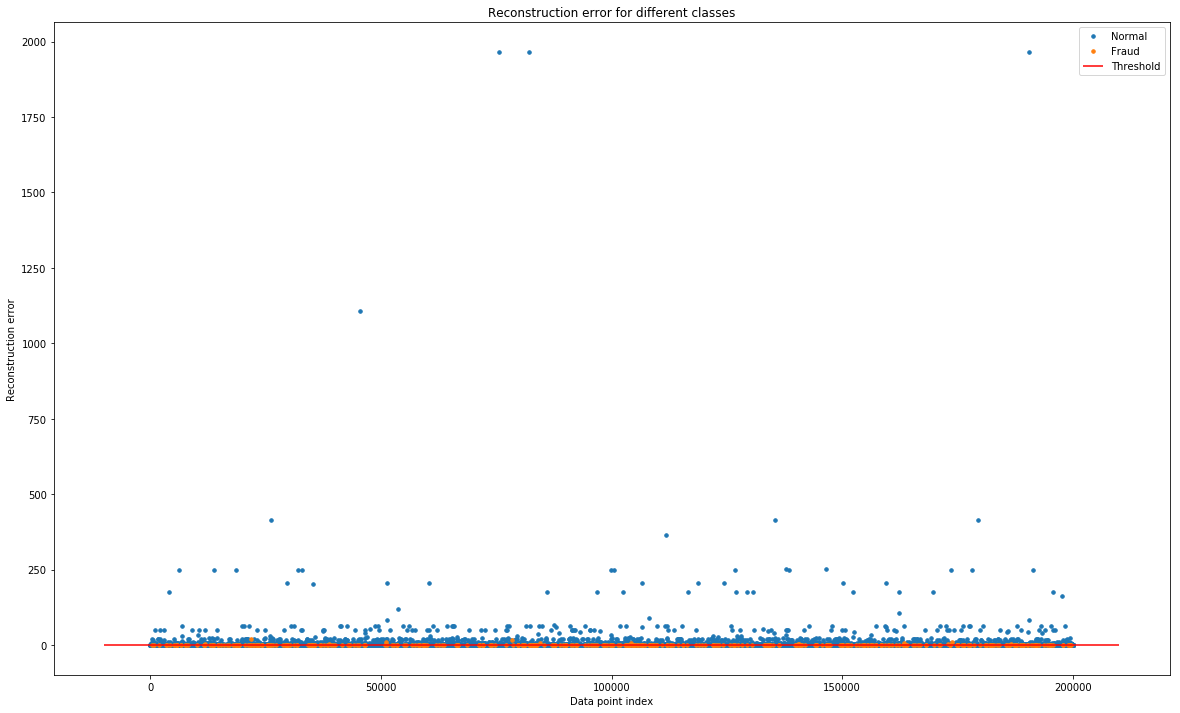

In [92]:
threshold = 1

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(20, 12))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [93]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

y_pred = [1 if e > 0.5 else 0 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)
f1 = f1_score(error_df.true_class, y_pred)

rtb_confusion_matrix(error_df.true_class, y_pred)
print("f1 = %0.3f" % f1)

print("ROC AUC score %0.3f" % roc_auc_score(error_df.true_class, y_pred))

Confusion Matrix:
True Negative = 184891
False Negative = 326
True Positive = 51
False Positive = 14732
f1 = 0.007
ROC AUC score 0.531
